In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, wilcoxon, shapiro, ttest_ind, ranksums,ttest_1samp
import numpy as np
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

# control variables
doCT = 0 # mutually exlusive with doVOL
fusing = 1 # only for the CT 
doVOL = 1
remove_out = 1 # when running SPC (i.e. the last block of code this must be at zero, otherwise it does not run anyways :))

save_path = '/home/riccardo/codici_progetti/Salerno/distributions_figure'
suffix = '' # '' empty (for roaw data, i.e. no residuals visualization) _residuals_MCI (for MCI effect) residuals_fenotipo (for fenotipo effect) residuals_ (for time effect)

def insert_nan(df, roi_names):
    df_copy = df.copy()
    outlier_subjects = []

    for roi in roi_names:
        # Detect outliers using IQR and replace with NaN
        Q1 = df_copy[roi].quantile(0.25, interpolation='midpoint')
        Q3 = df_copy[roi].quantile(0.75, interpolation='midpoint')
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outlier mask
        mask = (df_copy[roi] < lower_bound) | (df_copy[roi] > upper_bound)

        # Replace outliers with NaN
        df_copy.loc[mask, roi] = np.nan

        # Save Subj_IDs of outliers
        outlier_subjects.extend(df_copy.loc[mask, 'Subj_ID'].tolist())

    # Get unique subject IDs
    unique_outlier_subjects = sorted(set(outlier_subjects))

    return df_copy, unique_outlier_subjects


def distribution(df, cols_to_plot, var_to_plot, grouping=None, xlabel=None, ylabel=None, save_path=None):
    """Plot violin plot (with inner boxplot and outliers as stripplot) of the data.
    If grouping is 'Time', connect each subject's T0 and T1 values with lines per ROI."""
    font_size = 18
    if grouping:

        
        if "Phenotype" in grouping:
            df_long = df[cols_to_plot + ['Subj_ID', grouping,'Time']].melt(id_vars=['Subj_ID', grouping,'Time'],
                                                                 var_name=var_to_plot,
                                                                 value_name='Value')   
        else:
            df_long = df[cols_to_plot + ['Subj_ID', grouping]].melt(id_vars=['Subj_ID', grouping],
                                                                 var_name=var_to_plot,
                                                                 value_name='Value')
        # Define palette
        if 'Time' in grouping:
            palette = {'BL': '#0072B2', 'FUP': '#E69F00'}
        elif 'MCI' in grouping:
            palette = {'MCI_NO': '#56B4E9', 'MCI_YES': '#D55E00'}
        elif 'Phenotype' in grouping:
            palette = {'C': '#009E73', 'P': '#CC79A7'}
        else:
            palette = 'Set2'
    else:
        
        df_long = df[cols_to_plot + ['Subj_ID']].melt(id_vars='Subj_ID',
                                                       var_name=var_to_plot,
                                                       value_name='Value')
        palette = 'Set2'

    plt.figure(figsize=(15, 10))
    plt.xticks(rotation=45, ha='right')

    # Violin plot
    #ax = sns.violinplot(
    #    x=var_to_plot, y='Value', hue=grouping, data=df_long,
    #    palette=palette, split=True if grouping else False,
    #    inner='box', linewidth=1.2
    #)
    # Boxplot instead of violin
    if grouping:
        ax = sns.boxplot(
            x=var_to_plot, y='Value', hue=grouping, data=df_long,
            palette=palette, dodge=True, width=1, linewidth = 2, fliersize=0,zorder=1)
    else: 
        ax = sns.boxplot(
            x=var_to_plot, y='Value', hue=var_to_plot, data=df_long,
            palette=palette, dodge=True, width=1, linewidth = 2, fliersize=0,zorder=1)

    # Make boxplots unfilled
    for artist in ax.artists:
        artist.set_facecolor('none')     # Remove fill
        artist.set_edgecolor('black')    # Set edge color
        artist.set_linewidth(1.2)  

    # Add stripplot
    if "Phenotype" in grouping:
        sns.stripplot( x=var_to_plot, y='Value', hue=grouping, 
                        data=df_long[df_long['Time'] == 'BL'],  # Filter for BL only
                        dodge=True, jitter=True, marker='D',    # Diamonds for BL
                        palette=palette, linewidth=0.8, alpha=0.5, edgecolor='auto', zorder=2)
        df_long.to_csv('prova_df_long.csv')
        sns.stripplot( x=var_to_plot, y='Value', hue=grouping, 
                        data=df_long[df_long['Time'] == 'FUP'],  # Filter for FUP only
                        dodge=True, jitter=True, marker='s',    # Squares for FUP
                        palette=palette, linewidth=0.8, alpha=0.5, edgecolor='auto', zorder=2)

    else: 
        sns.stripplot(
            x=var_to_plot, y='Value', hue=grouping, data=df_long,
            dodge=True if grouping else False, jitter=True,
            palette=palette, linewidth=0.8, alpha=0.8, edgecolor='auto',zorder=2)


    # Connect paired values with lines if grouping == 'Time'
    if grouping == 'Time':
        roi_names = cols_to_plot
        group_levels = sorted(df[grouping].dropna().unique())  # Should be ['T0', 'T1']
        dodge_amount = 0.2  # Same as Seaborn’s default dodge

        for i, roi in enumerate(roi_names):
            temp = df[[roi, grouping, 'Subj_ID']].dropna()
            #temp = temp.pivot(index='Subj_ID', columns=grouping, values=roi)
            mean_values = temp.groupby(grouping)[roi].mean()

            #for subj in temp.index:
            #    if all(g in temp.columns for g in group_levels):
            #        y0 = temp.loc[subj, group_levels[0]]
            #        y1 = temp.loc[subj, group_levels[1]]
            #        color = (0.835, 0.369, 0.0)if y1 > y0 else (0.0, 0.62, 0.451)

            #        x_coords = [i - dodge_amount, i + dodge_amount]  # Align with Seaborn's dodge
            #        y_coords = [y0, y1]
            #        plt.plot(x_coords, y_coords, color=color, alpha=0.8, linewidth=1.4, zorder=10)

            if all(g in mean_values for g in group_levels):
                y0 = mean_values[group_levels[0]]
                y1 = mean_values[group_levels[1]]
                x_coords = [i - dodge_amount, i + dodge_amount]
                y_coords = [y0, y1]

                plt.plot(x_coords, y_coords, color='black', linewidth=2.5, zorder=15)

    # Fix legend
    handles, labels = ax.get_legend_handles_labels()
    legend=ax.legend(handles[:len(set(df[grouping]))] if grouping else handles,
              labels[:len(set(df[grouping]))] if grouping else labels,
              title=grouping if grouping else None, fontsize=font_size)
    
    plt.setp(legend.get_texts(), fontweight='bold')
    plt.setp(legend.get_title(), fontweight='bold')

    #plt.title(f"Grouped by {grouping}" if grouping else "All group")

    if xlabel:
        plt.xlabel(xlabel,fontsize=font_size, fontweight='bold')
        plt.ylabel(ylabel,fontsize=font_size, fontweight='bold')
        plt.xticks(fontsize=font_size, fontweight='bold')
        plt.yticks(fontsize=font_size, fontweight='bold')
    sns.despine()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()

def do_stats(df, cols_to_plot, grouping):
    if grouping:
        unique_groups = df[grouping].unique()
        if len(unique_groups) == 2:
            g1, g2 = unique_groups
            print(f"\n--- Statistical Results ({g1} vs {g2}) ---")
            for col in cols_to_plot:
                vals1 = df[df[grouping] == g1][col].dropna()
                vals2 = df[df[grouping] == g2][col].dropna()
                print(f"\n{col}:")
                
                # Paired assumption (same length, assume order matters)
                paired = len(vals1) == len(vals2)

                if paired:
                    try:
                        diff = vals1.values - vals2.values
                        stat_norm, p_norm = shapiro(diff)
                        if p_norm > 0.05:
                            stat, pval = ttest_rel(vals1, vals2)
                            test_name = "Paired t-test"
                        else:
                            stat, pval = wilcoxon(vals1, vals2)
                            test_name = "Wilcoxon signed-rank"
                    except ValueError:
                        pval = np.nan
                        test_name = "Insufficient data"
                else:
                    # Unpaired test
                    try:
                        norm1 = shapiro(vals1)[1]
                        norm2 = shapiro(vals2)[1]
                        if norm1 > 0.05 and norm2 > 0.05:
                            stat, pval = ttest_ind(vals1, vals2, equal_var=False)
                            test_name = "Unpaired t-test"
                        else:
                            stat, pval = ranksums(vals1, vals2)
                            test_name = "Mann–Whitney U (unpaired)"
                    except ValueError:
                        pval = np.nan
                        test_name = "Error in unpaired test"
                
                print(f"Test: {test_name}, p = {pval:.4f}")
        else:
            print("More than 2 groups: no pairwise test applied.")

# dataframe have data per each rpoi 
if doCT == 1 and doVOL == 0:
    if fusing == 1:
        data = pd.read_csv('/home/riccardo/codici_progetti/Salerno/stats_results_lme/all_data_ct_fusingroi.csv')
        roi_names = ['Frontal', 'Parietal', 'Temporal', 'Occipital', 'ACC', 'PCC', 'Insula'] 
        roi_names = [i + suffix for i in roi_names]
        varname = 'CT merged [mm]'
        data_lme =  pd.read_csv(f"/home/riccardo/codici_progetti/Salerno/stats_results_lme_final/lme_tot_ct_fused_remove_outliers_{remove_out}.csv")
    elif fusing == 0:
        data = pd.read_csv('/home/riccardo/codici_progetti/Salerno/stats_results_lme/all_data_ct_singleroi.csv')
        #roi_names = ['caudalanteriorcingulate', 'caudalmiddlefrontal', 'cuneus', 'entorhinal', 'fusiform', 'inferiorparietal', 'inferiortemporal', 'isthmuscingulate', 'lateraloccipital', 'lateralorbitofrontal', 'lingual', \
        #             'medialorbitofrontal', 'middletemporal', 'parahippocampal','paracentral', 'parsopercularis', 'parsorbitalis', 'parstriangularis',  'pericalcarine', 'postcentral', 'posteriorcingulate', 'precentral', \
        #             'precuneus', 'rostralanteriorcingulate', 'rostralmiddlefrontal', 'superiorfrontal', 'superiorparietal', 'superiortemporal',  'supramarginal', 'transversetemporal', 'insula'] 
        roi_names = ['superiorfrontal', 'caudalmiddlefrontal','rostralmiddlefrontal', 'parstriangularis', 'parsopercularis', 'parsorbitalis','lateralorbitofrontal', 'medialorbitofrontal', 'precentral', \
                     'paracentral',  'superiorparietal', 'inferiorparietal', 'supramarginal', 'postcentral', 'precuneus', 'superiortemporal', 'middletemporal', 'inferiortemporal', 'fusiform', 'transversetemporal', \
                    'parahippocampal', 'entorhinal',  'lateraloccipital', 'lingual',  'cuneus', 'pericalcarine','rostralanteriorcingulate','caudalanteriorcingulate', 'posteriorcingulate','isthmuscingulate','insula']
        roi_names = [i + suffix for i in roi_names]
        varname = 'CT '
        data_lme =  pd.read_csv(f"/home/riccardo/codici_progetti/Salerno/stats_results_lme_final/lme_tot_ct_singleroi_remove_outliers_{remove_out}.csv")
    if 'residuals' in suffix:
        ylab = 'Residuals CT'
    else:
        ylab = 'CT [mm]'
    save_figure = f"{save_path}/CT_fusing{fusing}_"
elif doCT == 0 and doVOL == 1:
    data_vol = pd.read_csv('/home/riccardo/codici_progetti/Salerno/stats_results_lme/all_data_vol.csv')
    data_vol_bs = pd.read_csv('/home/riccardo/codici_progetti/Salerno/stats_results_lme/all_data_vol_brainstem.csv')
    # drop all columns from brainsterm which are already in voume 
    to_drop=['Et_', 'Sesso', 'DurataMalattia_anni_', 'SottotipoMotorio', 'MCI_s__1_no_0_', 'UMSARSI', 'UMSARSI_1',  'UMSARSII', 'UMSARSII_1', 'UMSARSIV', 'UMSARSIV_1', 'deltaUMSARSI', \
             'deltaUMSARSII', 'deltaUMSARSIV', 'Time', 'UMSARSIcov', 'UMSARSIIcov', 'UMSARSIcov_centered', 'UMSARSIIcov_centered','totalIntracranial']
    data_vol_bs.drop(columns=to_drop , inplace = True)

    #data = pd.merge(data_vol, data_vol_bs, on = 'Subj_ID', how = 'inner')
    if data_vol['Subj_ID'].all() == data_vol_bs['Subj_ID'].all():
        if not suffix:
            data = pd.concat([data_vol, data_vol_bs['Pons']],axis = 1)
        elif "time" in suffix:
            data = pd.concat([data_vol, data_vol_bs[['Pons','Pons_residuals_time']]],axis = 1)
        elif "MCI" in suffix:
            data = pd.concat([data_vol, data_vol_bs[['Pons','Pons_residuals_MCI']]],axis = 1)
        elif "fenotipo" in suffix:
            data = pd.concat([data_vol, data_vol_bs[['Pons','Pons_residuals_fenotipo']]],axis = 1)

    data.rename(columns={"CerebellumWhiteMatter": "CerebWM", "CerebellumCortex":"CerebGM"}, inplace = True)
    roi_names = ['Putamen','CerebWM', 'CerebGM', 'Pons'] # 'Medulla', 'Midbrain',  'brain_stem' 'Thalamus', 'Caudate','Pallidum', 
    roi_names = [i + suffix for i in roi_names]
    print(roi_names)
    varname = 'Vol Normalized ICV '
    if 'residuals' in suffix:
        ylab = 'Residuals Volume Normalized ICV'
    else:
        ylab = 'Vol Normalized ICV [%]'#2CA02C
    save_figure = f"{save_path}/VOL_"
    
    data_lme =  pd.read_csv(f"/home/riccardo/codici_progetti/Salerno/stats_results_lme_final/lme_tot_vol_remove_outliers_{remove_out}.csv")

    data_lme.rename(columns={"CerebellumWhiteMatter": "CerebWM", "CerebellumCortex":"CerebGM","CerebellumWhiteMatter_estimate": "CerebWM_estimate", "CerebellumCortex_estimate":"CerebGM_estimate"}, inplace = True)

data['MCI_s__1_no_0_'] = data['MCI_s__1_no_0_'].map({0: 'MCI_NO', 1: 'MCI_YES'})
data.rename(columns={"SottotipoMotorio": "Phenotype"}, inplace = True)

data['Time'] = data['Time'].map({'T0': 'BL', 'T1': 'FUP'})
print(data.shape)



['Putamen', 'CerebWM', 'CerebGM', 'Pons']
(72, 43)


Figure saved to /home/riccardo/codici_progetti/Salerno/distributions_figure/VOL__groupedbyTime__outliers_removed_0.png


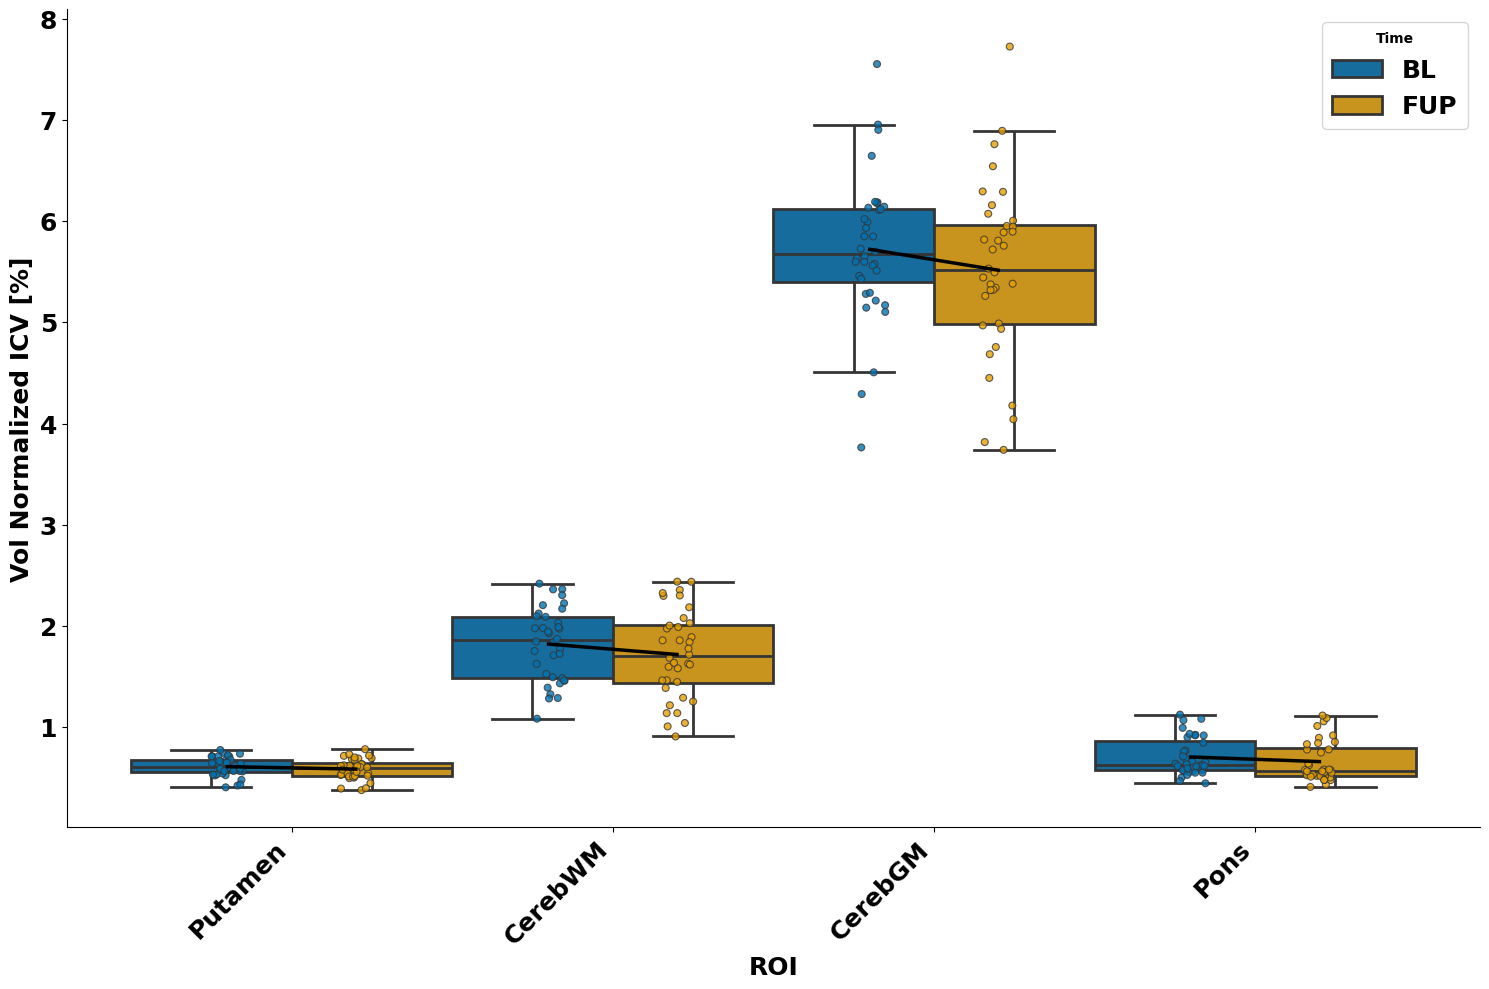

Figure saved to /home/riccardo/codici_progetti/Salerno/distributions_figure/VOL__groupedbyPhenotype__outliers_removed_0.png


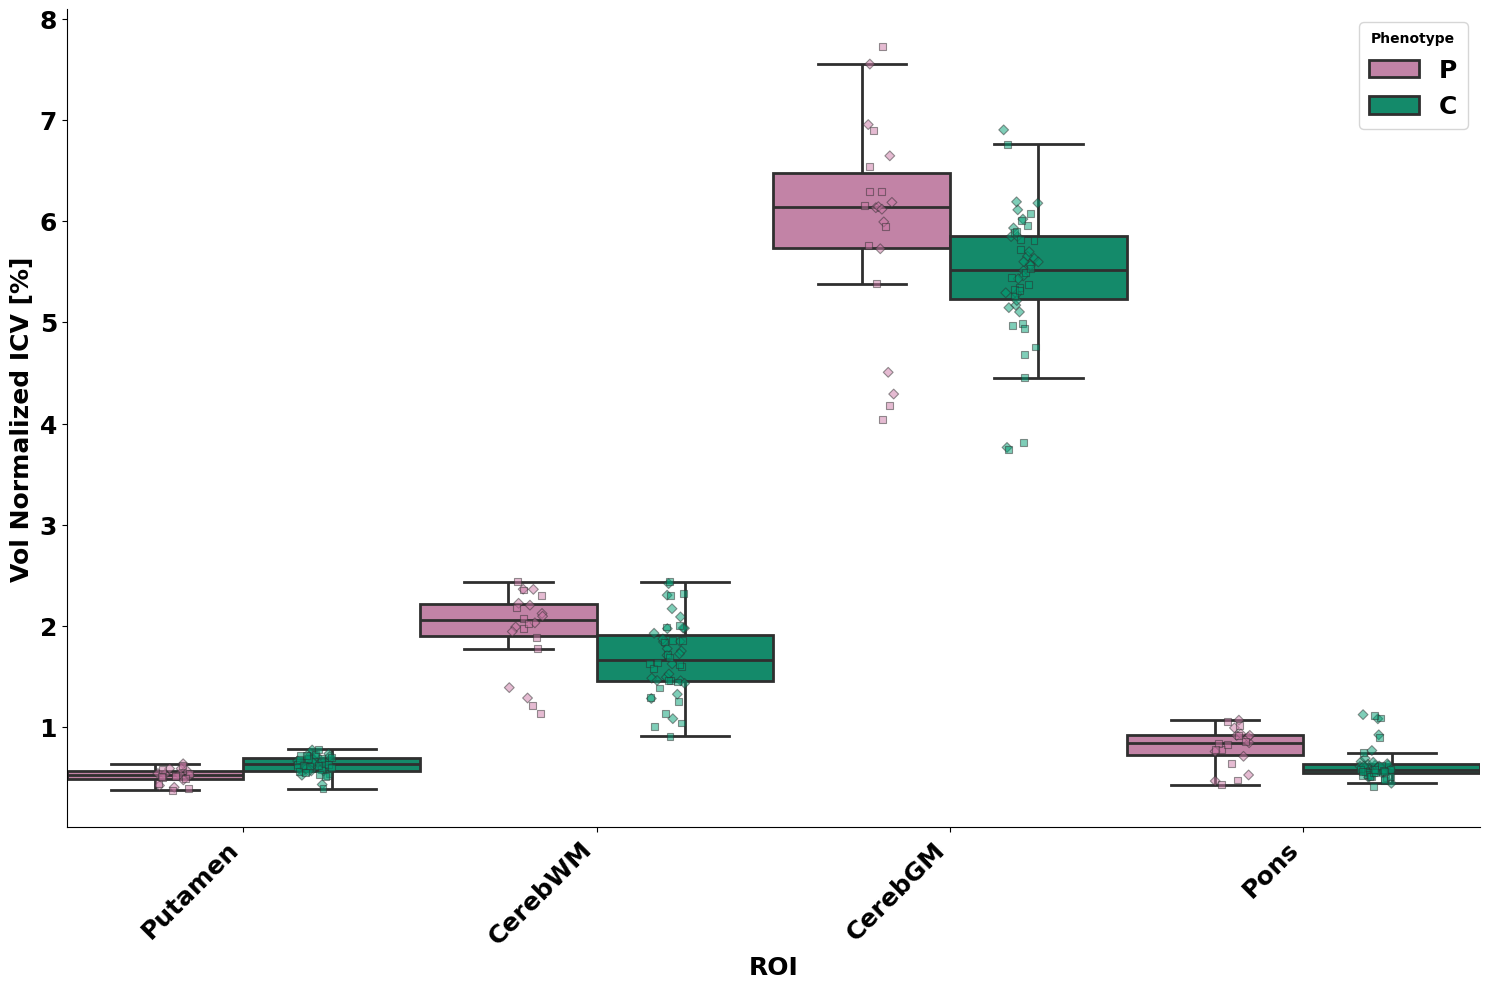

In [6]:
# if remove_out is 1 remove outliers from the datafram
if remove_out == 1:
        #data.to_csv('prova.csv', index = False)
        data_clean, subject_outlier = insert_nan(data, roi_names)  # consitent wat to remove the outliers
        print(subject_outlier)
        data = data[~data['Subj_ID'].isin(subject_outlier)]
        
if not suffix: # visualize raw data 
        #distribution(data,roi_names, varname, [], 'ROI', ylab, f"{save_figure}_withingroup_{suffix}_outliers_removed_{remove_out}.png")
        distribution(data,roi_names, varname, 'Time', 'ROI', ylab, f"{save_figure}_groupedbyTime_{suffix}_outliers_removed_{remove_out}.png")
        distribution(data,roi_names, varname, 'Phenotype', 'ROI', ylab, f"{save_figure}_groupedbyPhenotype_{suffix}_outliers_removed_{remove_out}.png")
        #do_stats(data,roi_names,'Time')
    #elif "time" in suffix: 
    #    distribution(data,roi_names, varname, 'Time', 'ROI', ylab, f"{save_figure}_groupedbytime_{suffix}_outliers_removed_{remove_out}.png")
    #    do_stats(data,roi_names,'Time')
    #elif "MCI" in suffix:
    #    distribution(data,roi_names, varname, 'MCI_s__1_no_0_', 'ROI', ylab, f"{save_figure}_groupedbyMCI_{suffix}.png")
    #    do_stats(data,roi_names,'MCI_s__1_no_0_')
    #elif "fenotipo" in suffix:
    #    distribution(data,roi_names, varname, 'Phenotype', 'ROI', ylab, f"{save_figure}_groupedbyfenotipo_{suffix}.png")
    #    do_stats(data,roi_names,'Phenotype')

/tmp/ipykernel_58012/2749647229.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cat = df_pvals.applymap(pval_category)
/tmp/ipykernel_58012/2749647229.py:46: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_colors = df_cat.applymap(lambda x: color_map[x])


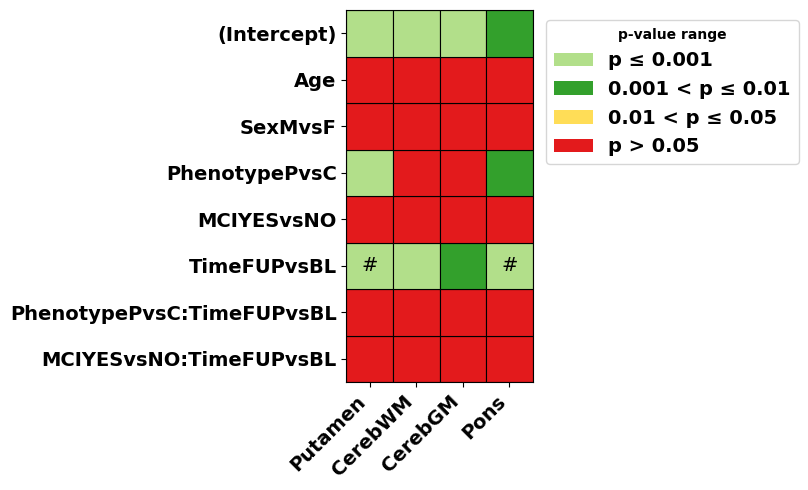

                      Labels  Putamen_estimate       Putamen  \
0                (Intercept)            0.7390  1.314530e-07   
1                        Age           -0.0014  4.970207e-01   
2                    SexMvsF           -0.0126  6.222976e-01   
3              PhenotypePvsC           -0.1185  7.597502e-05   
4                 MCIYESvsNO           -0.0087  7.452045e-01   
5                TimeFUPvsBL           -0.0271  2.047932e-05   
6  PhenotypePvsC:TimeFUPvsBL           -0.0051  5.411067e-01   
7     MCIYESvsNO:TimeFUPvsBL            0.0096  2.190385e-01   

   CerebWM_estimate   CerebWM  CerebGM_estimate       CerebGM  Pons_estimate  \
0            2.3451  0.000138            6.5371  5.654140e-07         0.8256   
1           -0.0094  0.334162           -0.0141  4.753624e-01        -0.0027   
2           -0.0565  0.633437           -0.1495  5.355723e-01        -0.0310   
3            0.2442  0.066902            0.4046  1.359105e-01         0.1656   
4           -0.0106  0.

In [92]:
# --- Extract labels and p-value columns ---
label_col = 'Labels'
data_lme[label_col] = data_lme[label_col].str.replace('Et_', 'Age', regex=False)
data_lme[label_col] = data_lme[label_col].str.replace('Sesso_M', 'SexMvsF', regex=False)
data_lme[label_col] = data_lme[label_col].str.replace('SottotipoMotorio_P', 'PhenotypePvsC', regex=False)
data_lme[label_col] = data_lme[label_col].str.replace('MCI_s__1_no_0__1', 'MCIYESvsNO', regex=False)
data_lme[label_col] = data_lme[label_col].str.replace('Time_T1', 'TimeFUPvsBL', regex=False)
data_lme[label_col] = data_lme[label_col].str.replace('SottotipoMotorio_P:Time_T1', 'PhenotypePvsCxTimeFUPvsBL', regex=False)
data_lme[label_col] = data_lme[label_col].str.replace('MCI_s__1_no_0__1:Time_T1', 'MCIYESvsNOxTimeFUPvsBL', regex=False)
data_lme[label_col] = data_lme[label_col].str.replace('Sesso_M', 'Sex', regex=False)
data_lme[label_col] = data_lme[label_col].str.replace('Sesso_M', 'Sex', regex=False)
pval_cols = [col for col in data_lme.columns if not col.endswith('_estimate')]
df_pvals = data_lme[[label_col] + pval_cols].copy()
df_pvals.set_index(label_col, inplace=True)
font_size=14
# --- Create a categorical matrix based on p-value thresholds ---
def pval_category(p):
    if p < 0.001:
        return 'p ≤ 0.001'
    elif p < 0.01:
        return '0.001 < p ≤ 0.01'
    elif p < 0.05:
        return '0.01 < p ≤ 0.05'
    else:
        return 'p > 0.05'

df_cat = df_pvals.applymap(pval_category)
# Fix MultiIndex and reverse order
if isinstance(df_cat.index, pd.MultiIndex):
    df_cat.index = df_cat.index.map(lambda x: '_'.join(map(str, x)))
    df_pvals.index = df_pvals.index.map(lambda x: '_'.join(map(str, x)))

# Reverse the row order
df_cat = df_cat.iloc[::-1]
df_pvals = df_pvals.iloc[::-1]

# --- Define colorblind-friendly palette ---
color_map = {
    'p ≤ 0.001': '#b2df8a',       # light green
    '0.001 < p ≤ 0.01': '#33a02c',  # dark green
    '0.01 < p ≤ 0.05': '#ffdd57', # yellow
    'p > 0.05': '#e31a1c',        # red
}

# --- Map categories to colors ---
df_colors = df_cat.applymap(lambda x: color_map[x])

# --- Plotting the heatmap using matplotlib patches ---
fig, ax = plt.subplots(figsize=(len(pval_cols) * 1 + 2, len(df_cat) * 0.5 + 1))

# Plot heatmap as colored rectangles with annotations
n_rows, n_cols = df_cat.shape

for i in range(n_rows):
    for j in range(n_cols):
        category = df_cat.iloc[i, j]
        value = df_pvals.iloc[i, j]
        color = color_map[category]
        #ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))
        ax.add_patch(plt.Rectangle(
            (j, i), 1, 1,
            facecolor=color,
            edgecolor='black',  # grid line color
            linewidth=0.8       # grid line thickness
        ))
        if doVOL == 1 and doCT == 0:
            if i == 2 and j == 0 or i == 2 and j == 3:
                ax.text(j + 0.5, i + 0.5, f'#', ha='center', va='center', fontsize=font_size)
        elif doVOL == 0 and doCT == 1 and fusing == 0:
            if i == 2 and j == 13 or i == 2 and j == 28 or i == 2 and j == 29:
                ax.text(j + 0.5, i + 0.5, f'#', ha='center', va='center', fontsize=font_size)
        elif doVOL == 0 and doCT == 1 and fusing == 1:
            if i == 2 and j == 0 or i == 2 and j == 1 or i == 2 and j == 5 or i == 2 and j == 6:
                ax.text(j + 0.5, i + 0.5, f'#', ha='center', va='center', fontsize=font_size)
        
# Axis formatting
ax.set_xticks(np.arange(len(df_cat.columns)) + 0.5)
ax.set_xticklabels(df_cat.columns, rotation=45, ha='right',fontsize=font_size, fontweight='bold')
ax.set_yticks(np.arange(len(df_cat.index)) + 0.5)
ylabs= df_cat.index.map(lambda x: x[0])
ax.set_yticklabels(ylabs, fontsize=font_size, fontweight='bold')
ax.invert_yaxis()
ax.set_xlim(0, len(df_cat.columns))
ax.set_ylim(0, len(df_cat.index))
ax.set_aspect('equal')
# --- Add legend ---
legend_elements = [Patch(facecolor=color_map[k], label=k) for k in color_map]
legend=ax.legend(handles=legend_elements, title='p-value range', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=font_size)
plt.setp(legend.get_texts(), fontweight='bold')
plt.setp(legend.get_title(), fontweight='bold')

# Title and layout
#if doVOL == 1 and doCT == 0:
    #plt.title("Infratentorial and Putamen", fontsize=14)
#elif doVOL == 0 and doCT == 1 and fusing == 0:
    #plt.title("Cortical each ROI", fontsize=14)
#elif doVOL == 0 and doCT == 1 and fusing == 1:
    #plt.title("Cortical merged ROI", fontsize=14)

plt.tight_layout()

plt.savefig(f"{save_figure}_heatmap_{suffix}_outliers_removed_{remove_out}.png", dpi=300, bbox_inches='tight')

plt.show()

print(data_lme)

36
(36, 43)
(36, 43)
Subj_ID    sub-05.sub-05_
Putamen        -11.246473
CerebWM        -33.992209
CerebGM        -20.935752
Pons           -14.590596
dtype: object
       ROI  Normality_p Test_used  Test_stat        Test_p
0  Putamen     0.006703  wilcoxon  42.000000  3.304740e-07
1  CerebWM     0.091385    t-test  -4.069641  2.551092e-04
2  CerebGM     0.183418    t-test  -4.069603  2.551372e-04
3     Pons     0.154412    t-test  -9.333561  4.991732e-11
with outliers below, without outlier above ###
       ROI  Normality_p Test_used  Test_stat        Test_p
0  Putamen     0.820070    t-test  -8.869263  2.294790e-10
1  CerebWM     0.635261    t-test  -4.904225  2.825732e-05
2  CerebGM     0.479966    t-test  -5.063076  1.531780e-05
3     Pons     0.154412    t-test  -9.333561  4.991732e-11


/tmp/ipykernel_58012/474374458.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(roi_names, rotation=45, ha='right', fontsize=14)


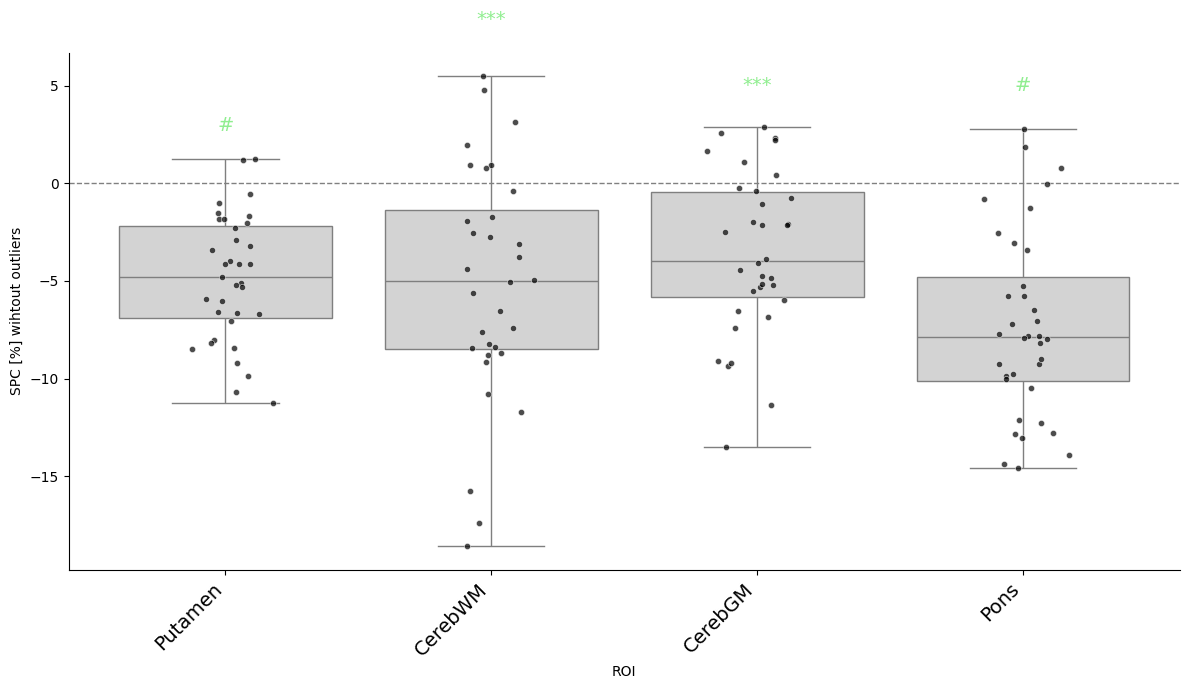

/tmp/ipykernel_58012/474374458.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(roi_names, rotation=45, ha='right', fontsize=14)


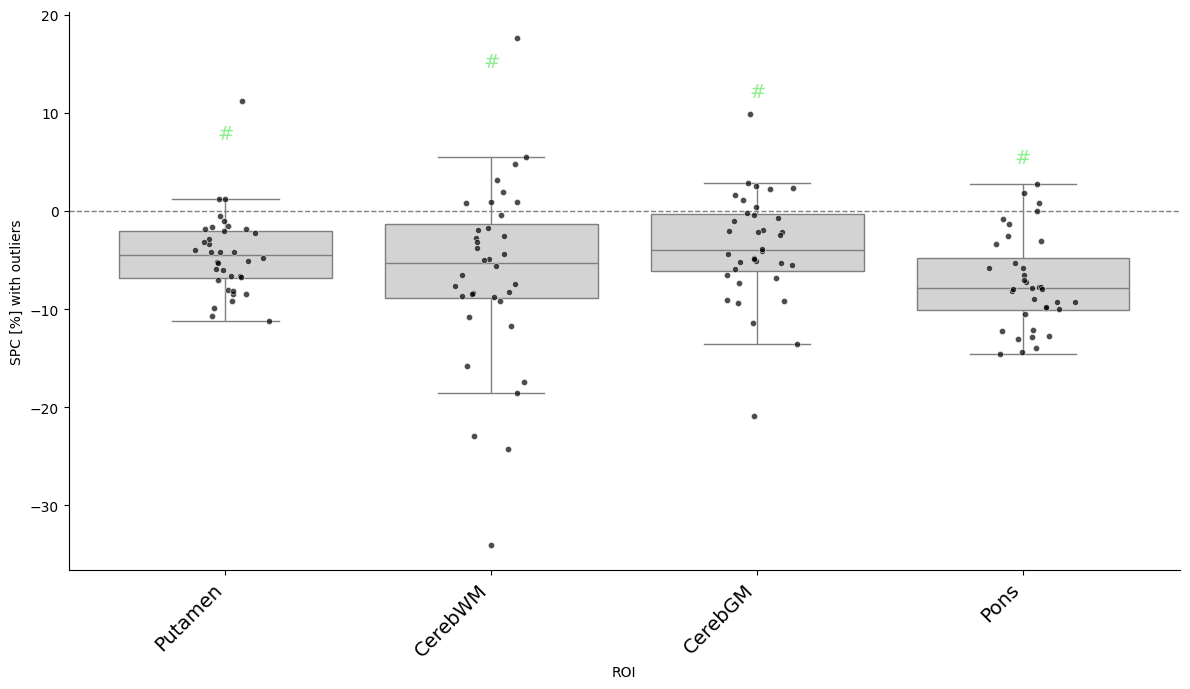

spc with outliers
            Mean ± SD
Putamen   -4.4 ± 4.16
CerebWM   -6.37 ± 9.4
CerebGM  -3.71 ± 5.48
Pons     -7.34 ± 4.72
spc without outliers
            Mean ± SD
Putamen  -4.85 ± 3.23
CerebWM  -5.18 ± 5.98
CerebGM  -3.61 ± 4.15
Pons     -7.34 ± 4.72


In [93]:
if remove_out == 0: # do this only when date with the outliers are NOT removed, I will removed the outliers here :) 

    def insert_nan_and_test(df, roi_names, do_stat_with_outlier):
        """
        Replace outliers with NaN per ROI using IQR,
        then test distribution normality and difference from zero.

        Parameters:
            df (pd.DataFrame): Input DataFrame
            roi_names (list of str): List of ROI column names
            do_stat_with_outlier (bool): If True, run stats on original data (with outliers)

        Returns:
            cleaned_df (pd.DataFrame): Copy of df with outliers replaced by NaN
            results (pd.DataFrame): Summary with normality and test results per ROI
        """
        df_copy = df.copy()
        results_list = []

        for roi in roi_names:
            # Detect outliers using IQR and replace with NaN
            Q1 = df_copy[roi].quantile(0.25)
            Q3 = df_copy[roi].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            mask = (df_copy[roi] < lower_bound) | (df_copy[roi] > upper_bound)
            df_copy.loc[mask, roi] = np.nan

            # Extract data for statistics
            if do_stat_with_outlier:
                data_clean = df[roi].dropna()  # from original input
            else:
                data_clean = df_copy[roi].dropna()  # after outlier removal

            # Default values
            normality_p = np.nan
            test_name = None
            test_stat = np.nan
            test_p = np.nan

            if len(data_clean) >= 3:
                # Normality test
                stat, p = shapiro(data_clean)
                normality_p = p

                # Test against zero
                if p > 0.05:
                    test_name = 't-test'
                    t_stat, t_p = ttest_1samp(data_clean, 0)
                    test_stat = t_stat
                    test_p = t_p
                else:
                    test_name = 'wilcoxon'
                    if np.any(data_clean != 0):
                        w_stat, w_p = wilcoxon(data_clean - 0)
                        test_stat = w_stat
                        test_p = w_p

                results_list.append({
                'ROI': roi,
                'Normality_p': normality_p,
                'Test_used': test_name,
                'Test_stat': test_stat,
                'Test_p': test_p
            })

        results = pd.DataFrame(results_list)
        return df_copy, results

                    

    def plot_roi_stats(df, roi_names, ylab, save_name, test_results = None):

        """
        Plot boxplot + scatter of ROI values with significance symbols above each ROI.

        Parameters:
            df (pd.DataFrame): DataFrame with ROI columns (cleaned data)
            roi_names (list of str): List of ROI column names to plot
            test_results (pd.DataFrame): DataFrame with columns ['ROI', 'Test_p']
        """

        def p_to_symbol_and_color(p):
            if p < 0 or np.isnan(p):
                return '', 'black'
            if p < 0.001 / len(roi_names):  # Bonferroni-like stricter threshold
                return '#', 'lightgreen'
            elif p < 0.001:
                return '***', 'lightgreen'
            elif p < 0.01:
                return '**', 'darkgreen'
            elif p < 0.05:
                return '*', 'gold'
            else:
                return 'ns', 'red'

        # Prepare plot
        plt.figure(figsize=(12, 7))  #(figsize=(max(12, 0.6 * len(roi_names)), 6))

        # Melt dataframe for seaborn
        plot_data = df[roi_names].melt(var_name='ROI', value_name='Value')

        # Boxplot (no outlier symbols)
        ax = sns.boxplot(x='ROI', y='Value', data=plot_data, color='lightgray', fliersize=0, showfliers = True)

        # Overlay scatter
        for i, roi in enumerate(roi_names):
            y = df[roi].dropna()
            if y.empty:
                continue
            q1 = np.percentile(y, 25)
            q3 = np.percentile(y, 75)
            iqr = q3 - q1
            lower_whisker = max(np.min(y), q1 - 1.5 * iqr)
            upper_whisker = min(np.max(y), q3 + 1.5 * iqr)

            # Scatter
            x_jitter = np.random.normal(i, 0.07, size=len(y))
            y_clipped = np.clip(y, lower_whisker, None)
            plt.scatter(x_jitter, y, alpha=0.7, color='black', s=20, edgecolors='w', linewidth=0.5, zorder=10)

            # Significance
            if test_results is not None and not test_results.empty:
                match = test_results.loc[test_results['ROI'] == roi, 'Test_p']
                if not match.empty:
                    p_val = match.values[0]
                    symbol, color = p_to_symbol_and_color(p_val)

                    if symbol:
                        y_pos = upper_whisker + (upper_whisker - np.min(y)) * 0.1
                        plt.text(i, y_pos, symbol, ha='center', va='bottom', fontsize=14, color=color, zorder=20) #  fontweight='bold'

        # Styling
        plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Horizontal line at zero
        plt.xticks(rotation=90)
        ax.set_xticklabels(roi_names, rotation=45, ha='right', fontsize=14)

        #plt.title('ROI values with significance')
        plt.ylabel(ylab)
        plt.tight_layout()

        # Remove all spines (box)
        sns.despine(top=True, right=True, left=False, bottom=False)

        plt.savefig(save_name, dpi=300, bbox_inches='tight')
        plt.show()



    nsubj=int(data.shape[0]/2)
    print(nsubj)
    BL = data.iloc[0:nsubj].reset_index(drop=True)
    FUP = data.iloc[nsubj:].reset_index(drop=True)

    print(BL.shape)
    print(FUP.shape)

    if not (BL['Subj_ID'].reset_index(drop=True) == FUP['Subj_ID'].reset_index(drop = True)).all():
        raise ValueError(f"Mismatch between BL and FUP subjects")

    if "FUP" in BL['Time'] or 'BL' in FUP['Time']:
        raise ValueError(f"Subdivision of dataframe is wrong")

    # SPC tot 
    spc = pd.DataFrame()
    spc['Subj_ID'] = BL['Subj_ID']
    for roi in roi_names:
        rate = (FUP[roi] - BL[roi])/(FUP['T1_T0_Diff_Days']/365)
        avg = 0.5*(FUP[roi] + BL[roi])
        spc[roi] = rate / avg * 100
    
    print(spc.min())

    spc_no_outliers , results_spc_without_outliers = insert_nan_and_test(spc, roi_names, True) # if True do statistics with outlier, if false do stat without outliers
    _ , results_spc_with_outliers = insert_nan_and_test(spc, roi_names, False)
    print(results_spc_without_outliers)
    print("with outliers below, without outlier above ###")
    print(results_spc_with_outliers)

    if doCT == 1 and doVOL == 0:
        plot_roi_stats(spc_no_outliers, roi_names, f"SPC [%] wihtout outliers", f"{save_path}/SPC_without_outlier_VOL_{doVOL}_CT{doCT}_fusing{fusing}.png", results_spc_without_outliers) 
        plot_roi_stats(spc, roi_names, f"SPC [%] with outliers", f"{save_path}/SPC_with_outlier_VOL_{doVOL}_CT{doCT}_fusing{fusing}.png", results_spc_with_outliers)
    elif doVOL == 1 and doCT == 0:
        plot_roi_stats(spc_no_outliers, roi_names, f"SPC [%] wihtout outliers", f"{save_path}/SPC_without_outlier_VOL_{doVOL}_CT{doCT}.png", results_spc_without_outliers) 
        plot_roi_stats(spc, roi_names, f"SPC [%] with outliers", f"{save_path}/SPC_with_outlier_VOL_{doVOL}_CT{doCT}.png", results_spc_with_outliers)
    
    # format an SPC table for the final pulication 
    desc_stats = spc.drop('Subj_ID', axis=1).agg(['mean', 'std']).transpose()
    desc_stats = desc_stats.round(2)
    desc_stats['Report'] = desc_stats.apply(lambda x: f"{x['mean']} ± {x['std']}", axis=1)
    final_table = desc_stats[['Report']].rename(columns={'Report': 'Mean ± SD'})

    # Display the table (for checking)
    print("spc with outliers")
    print(final_table)

    desc_stats_no = spc_no_outliers.drop('Subj_ID', axis=1).agg(['mean', 'std']).transpose()
    desc_stats_no = desc_stats_no.round(2)
    desc_stats_no['Report'] = desc_stats_no.apply(lambda x: f"{x['mean']} ± {x['std']}", axis=1)
    final_table_no = desc_stats_no[['Report']].rename(columns={'Report': 'Mean ± SD'})

    # Display the table (for checking)
    print("spc without outliers")
    print(final_table_no)
   